source: https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import argparse
from torchvision import models, transforms
from PIL import Image
from pathlib import Path
import zipfile
import PIL

target_size = 17037

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# old_mosaik_model = nn.Sequential(
#                   nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same', bias=True),
#                   nn.ReLU(),
#                   nn.MaxPool2d(2, stride=2),

#                   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same', bias=True),
#                   nn.ReLU(),
#                   nn.MaxPool2d(2, stride=2),

#                   nn.Flatten(),
#                   nn.Dropout(0.5),
#                   nn.Linear(200704, 512), #50176
#                   nn.ReLU(),
#                   nn.Linear(512, target_size)
#                   ) 
# mosaik_model_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/two_layers_mosaiks_kmeans.pt"
# mosaik_model.load_state_dict(torch.load(mosaik_model_path))

In [3]:
# with 7x7 kernel
kernel_size = "7-7"
mode = 'no_preprocess' #'no_norm'
mosaik_model = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding='same', bias=True),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding='same', bias=True),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
    
      nn.AdaptiveAvgPool2d(9),
    
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(5184, 512), #50176
      nn.ReLU(),
      nn.Linear(512, target_size)
      ) 
mosaik_model_path = f"/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/two_layer_mosaiks_kmeans_{kernel_size}_{mode}.pt"
mosaik_model.load_state_dict(torch.load(mosaik_model_path))

<All keys matched successfully>

In [4]:
# # with 3x3 kernel
# kernel_size = "3-3"
# mosaik_model = nn.Sequential(
#       nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same', bias=True),
#       nn.ReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same', bias=True),
#       nn.ReLU(),
#       nn.MaxPool2d(2, stride=2),
    
#       nn.AdaptiveAvgPool2d(9),
    
#       nn.Flatten(),
#       nn.Dropout(0.5),
#       nn.Linear(5184, 512), #50176
#       nn.ReLU(),
#       nn.Linear(512, target_size)
#       ) 
# mosaik_model_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/two_layer_mosaiks_kmeans_3-3.pt"
# mosaik_model.load_state_dict(torch.load(mosaik_model_path))

In [5]:
mosaik_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): AdaptiveAvgPool2d(output_size=9)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=5184, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=17037, bias=True)
)

In [6]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list

model_children = list(mosaik_model.children())
model_children

[Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=same),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 AdaptiveAvgPool2d(output_size=9),
 Flatten(start_dim=1, end_dim=-1),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=5184, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=17037, bias=True)]

In [7]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [8]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=same) ====> SHAPE: torch.Size([64, 3, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same) ====> SHAPE: torch.Size([64, 64, 7, 7])


# Visualizing Convolutional Layer Filters

In this section, we will visualize the convolutional layer filters. For the sake of simplicity, we will only visualize the filters of the first convolutional layer.

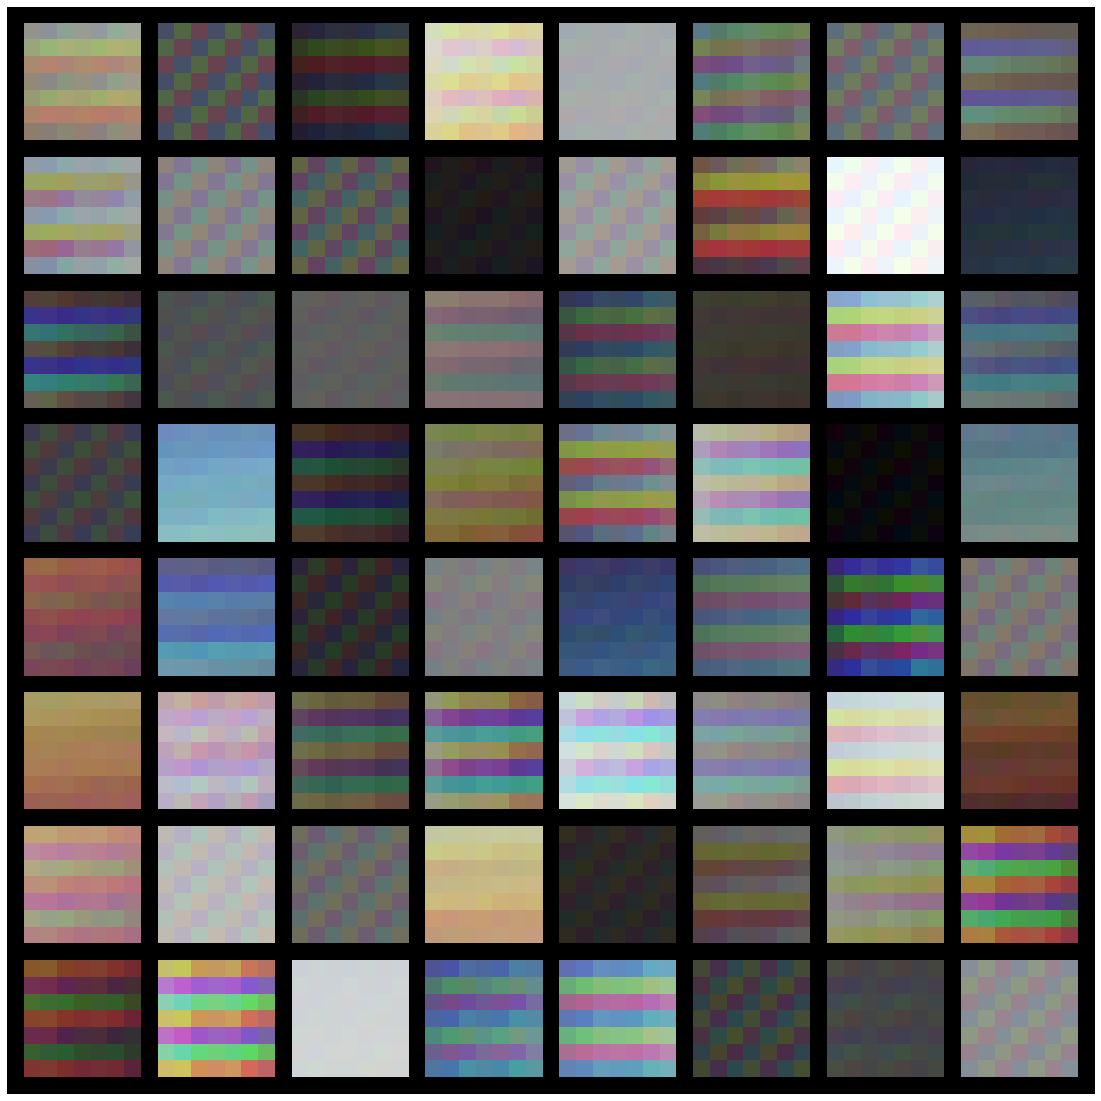

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(20,20) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


layer = 1
filter = model_weights[0].data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.rcParams['savefig.facecolor']='white'
plt.savefig(f'../images/mosaik_conv1_{kernel_size}_{mode}_filter_color.png')
plt.show()

In [10]:
model_weights[0].shape

torch.Size([64, 3, 7, 7])

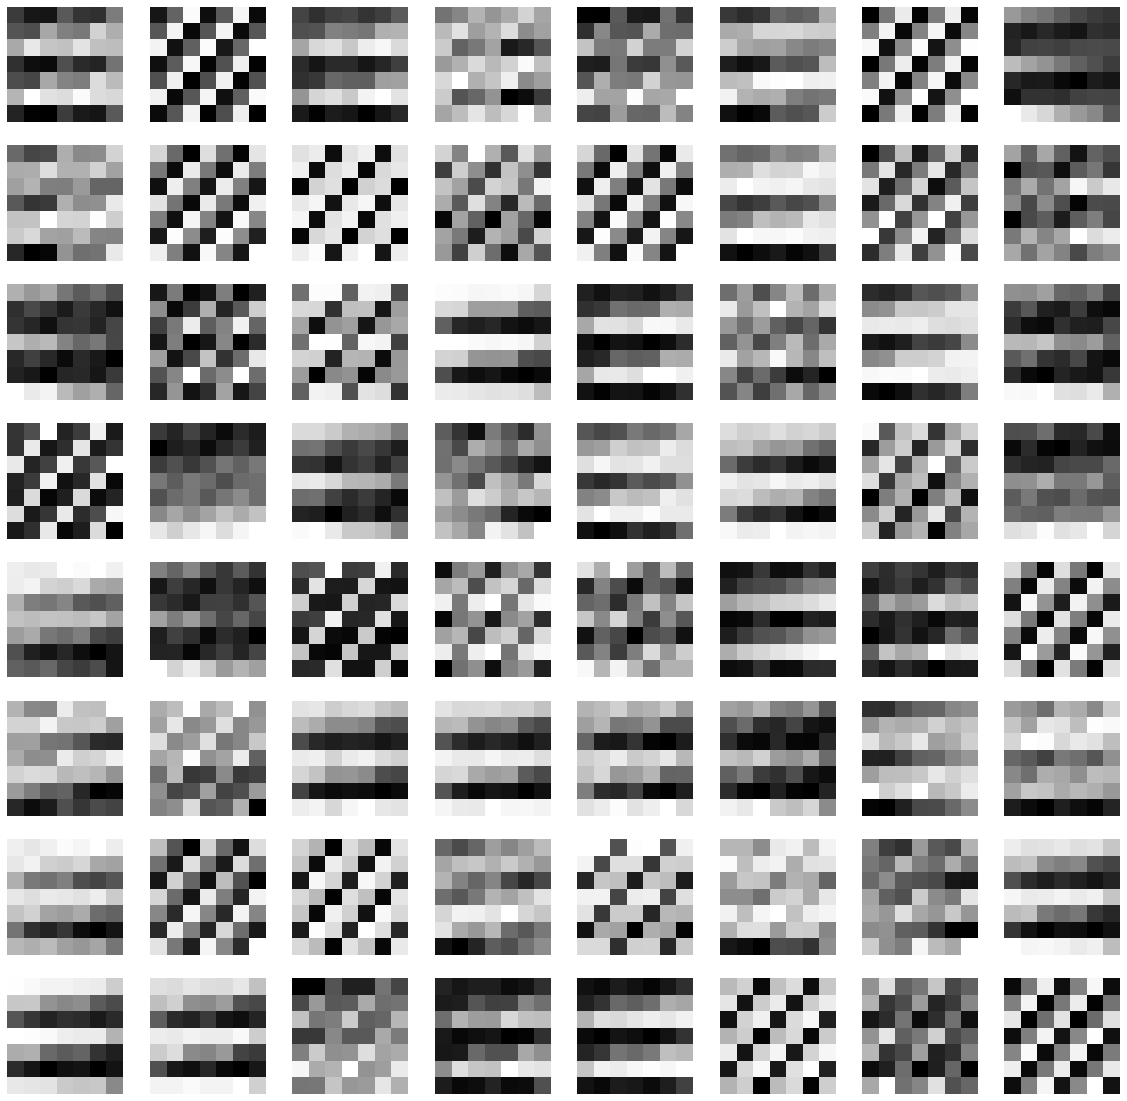

In [12]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 20))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) #  because in conv0 we have 3x3 filters and total of 32 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.rcParams['savefig.facecolor']='white'
    plt.savefig(f'../images/mosaik_conv1_{kernel_size}_{mode}_filter.png')
plt.show()

In [12]:
# visualize the 2nd conv layer filters

def get_top_filters(conv_filter_idx, top_k):
    
    num_filters, num_input_ch, w, h = model_weights[conv_filter_idx].shape
    norms = np.zeros((num_input_ch, num_filters))
    final_filters = np.zeros((num_input_ch, top_k, w, h))
    
    for input_filter_idx in range(num_input_ch):
        for new_filter_idx in range(num_filters):
            norms[input_filter_idx, new_filter_idx] = np.linalg.norm(
                            model_weights[conv_filter_idx][new_filter_idx, input_filter_idx, :, :].detach().numpy())
    
#     print(norms.shape)
    sorted_arr_idx = np.argsort(norms)
    top_indices = sorted_arr_idx[:, -top_k:, ]
#     print(top_indices.shape)
    for i, idx in enumerate(top_indices):
        final_filters[i] = model_weights[conv_filter_idx][top_indices[i], i,: ,:].detach().numpy()
        
    return final_filters

In [13]:
final_filters = get_top_filters(conv_filter_idx=1, top_k=3)
final_filters.shape

(64, 3, 7, 7)

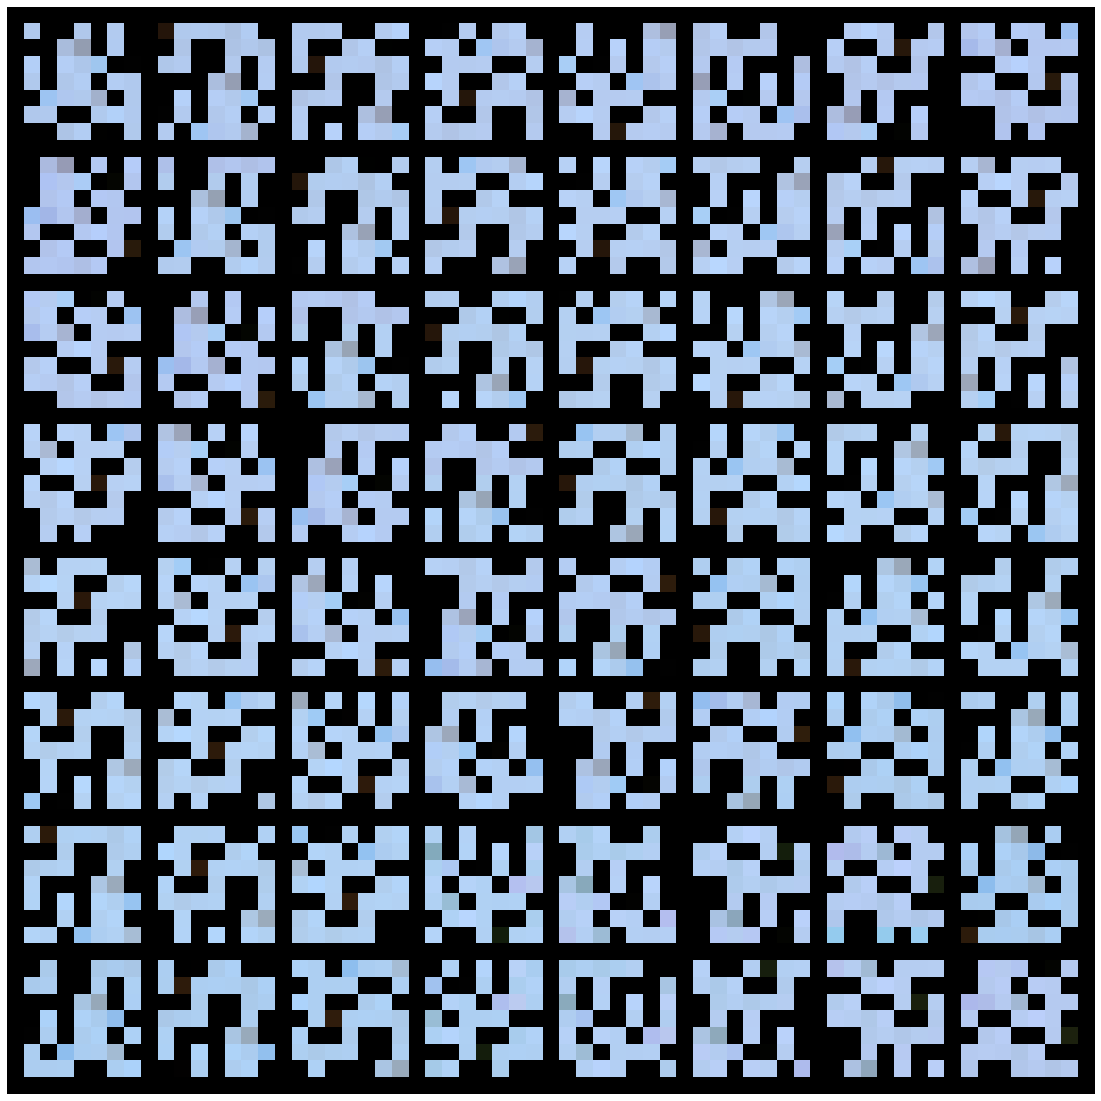

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(20,20) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


layer = 1
visTensor(torch.from_numpy(final_filters), ch=0, allkernels=False)

plt.rcParams['savefig.facecolor']='white'
plt.savefig(f'../images/mosaik_conv2_{kernel_size}_{mode}_filter_color.png')
plt.axis('off')
plt.ioff()
plt.show()

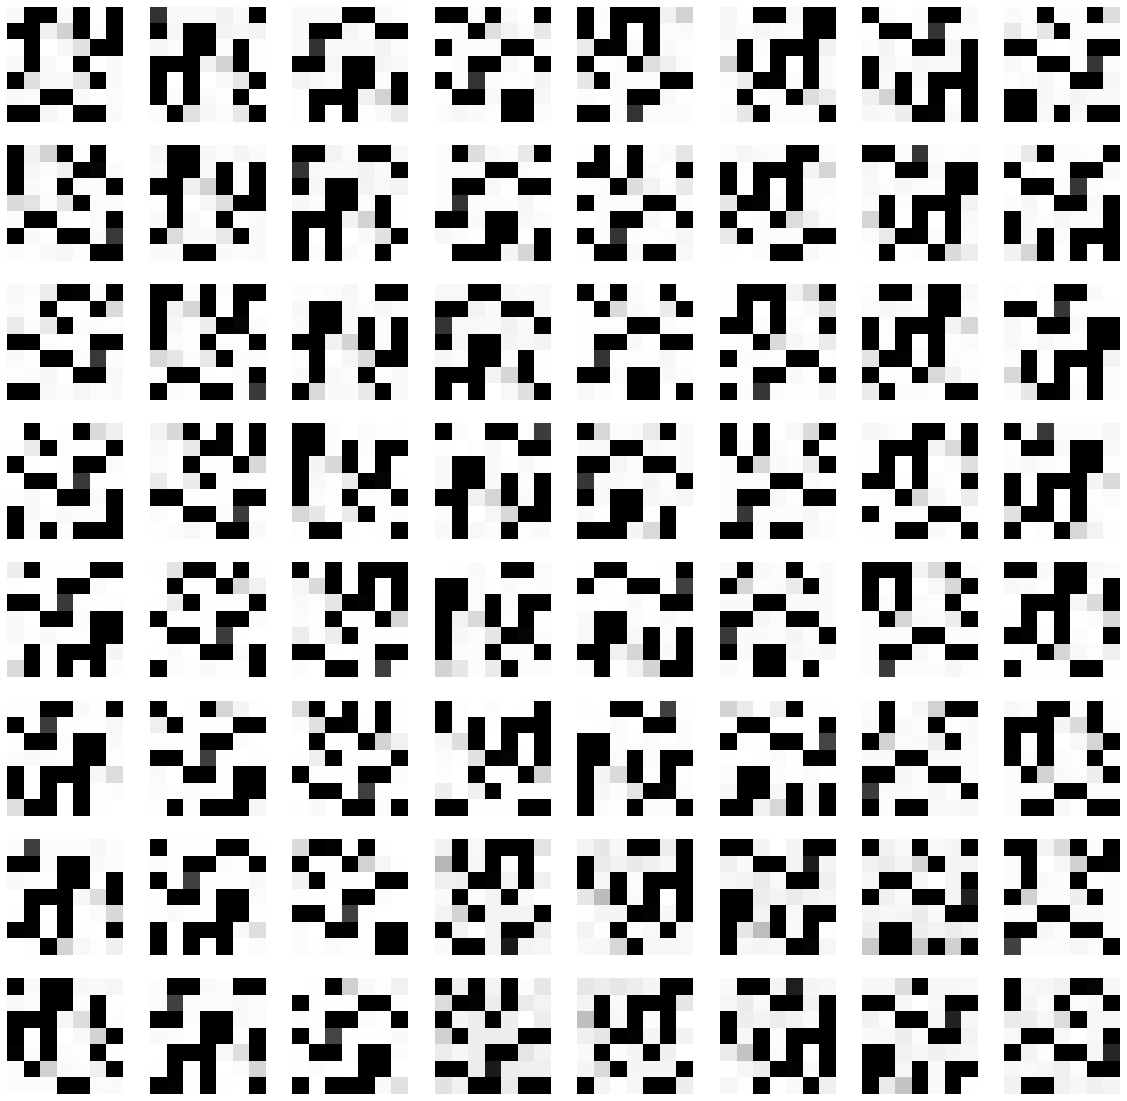

In [15]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 20))
for i, filter in enumerate(final_filters):
    plt.subplot(8, 8, i+1) #  because in conv0 we have 3x3 filters and total of 32 (see printed shapes)
    plt.imshow(filter[0, :, :], cmap='gray')
    plt.axis('off')
    plt.rcParams['savefig.facecolor']='white'
    plt.savefig(f'../images/mosaik_conv2_{kernel_size}__{mode}_filter.png')
plt.show()

# Reading the Image and Defining the Transforms

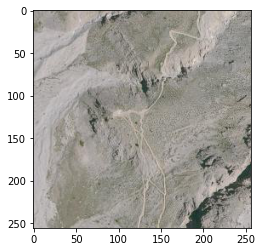

In [39]:
ex_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/patches-fr/00/00"
rgb_jpg = Image.open(Path(ex_path) / "10000000_rgb.jpg")
plt.imshow(rgb_jpg)
plt.rcParams['savefig.facecolor']='white'
plt.savefig('./images/test_satelite_img.jpg')
plt.show()

In [40]:
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

rgb_jpg = np.array(rgb_jpg)
# apply the transforms
rgb_jpg = transform(rgb_jpg)
print(rgb_jpg.size())
# unsqueeze to add a batch dimension
rgb_jpg = rgb_jpg.unsqueeze(0)
print(rgb_jpg.size())


torch.Size([3, 512, 512])
torch.Size([1, 3, 512, 512])


# Visualizing the Feature Maps of the Convolutional Layers

Visualizing the feature maps of the image after passing through the convolutional layers of the ResNet-50 model consists of two steps.

    Passing the image through each convolutional layer and saving each layer’s output.
    Visualizing the feature map blocks of each layer.

Before moving further, I would like to point out that visualizing the feature maps is not really necessary when doing any neural network projects. But if you are carrying out any large scale projects or writing a novel research paper, especially in the computer vision field, then it is very common to analyze the feature maps.

When reading deep learning computer vision research papers, then you may have noticed that many authors provide activation maps for the input image. This is specifically to show which part of the image activates that particular layer’s neurons in a deep neural network model. This gives the authors as well as the reader a good idea of **what the neural network sees**.

# Passing the Input Image Through Each Convolutional Layer

We will first give the image as an input to the first convolutional layer. After that, we will use a for loop to pass the last layer’s outputs to the next layer, until we reach the last convolutional layer.

In [41]:
# pass the image through all the layers
results = [conv_layers[0](rgb_jpg)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

# Visualizing the Feature Maps

This is the final step. We will write the code to visualize the feature maps that we just saved.

Notice that the upper layers (near the fully connected layers) have many feature maps, in the range of 512 to 2048. But we will only visualize 64 feature maps from each layer as any more than that will make the outputs really cluttered.

The following code shows how to iterate through each layer’s output and save the feature maps.

In [42]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.rcParams['savefig.facecolor']='white'
    plt.savefig(f"./images/mosaik_layer_{num_layer}.png")
    # plt.show()
    plt.close()

torch.Size([32, 512, 512])
Saving layer 0 feature maps...
torch.Size([64, 512, 512])
Saving layer 1 feature maps...


# What activates each feature map

In [5]:
# global variable to work with GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available(): print('Thanks Mila!')
print(device)

Thanks Mila!
cuda:0


In [6]:
mosaik_model.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=200704, out_features=512, bias=True)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=17037, bias=True)
)

In [7]:
new_model = nn.Sequential(*list(mosaik_model.children())[0:6])
new_model = nn.Sequential(*list(new_model.children()), nn.AdaptiveAvgPool2d(9))
new_model = nn.Sequential(*list(new_model.children()), 
                          nn.Flatten(), 
                          nn.Dropout(0.5),
                          nn.Linear(5184, 512),
                          nn.ReLU(),
                          nn.Linear(512, target_size))
new_model = new_model.to(device)
new_model.float()
# for idx, layer in enumerate(mosaik_model.children()):
#     new_model.add_module("avgpool", layer)
new_model(torch.rand((1, 3, 224, 224)).to(device)).shape

torch.Size([1, 17037])

In [8]:
new_model = new_model.double()

In [9]:
# list cnn layers
layers = [layer for layer in new_model.children()]
print('Layers: {}'.format(len(layers)))

Layers: 12


The idea is the following: we start with a picture containing random pixels. We apply the network in evaluation mode to this random image, calculate the average activation of a certain feature map in a certain layer from which we then compute the gradients with respect to the input image pixel values. Knowing the gradients for the pixel values we then proceed to update the pixel values in a way that maximizes the average activation of the chosen feature map.

I know that this might sound confusing so let’s explain it again in different words: The network weights are fixed, the network will not be trained, and we try to find an image that maximizes the average activation of a certain feature map by performing gradient descent optimization on the pixel values.

So what is this good for? Let’s say we are interested in the feature maps of layer i. We register a forward hook on layer i that, once the forward method of layer i is called, saves the features of layer i in a variable.

In [19]:
class SaveFeatures():
    def __init__(self, module, device=None):
        # we are going to hook some model's layer (module here)
        self.hook = module.register_forward_hook(self.hook_fn)
        self.device = device

    def hook_fn(self, module, input, output):
        # when the module.forward() is executed, here we intercept its
        # input and output. We are interested in the module's output.
        self.features = output.clone()
        if self.device is not None:
            self.features = self.features.to(device)
        self.features.requires_grad_(True)

    def close(self):
        # we must call this method to free memory resources
        self.hook.remove()

In [20]:
class FeatureMapVisualizer():
    def __init__(self, cnn, device, channels=3, layers_base=None, norm=None, denorm=None, save=None):
        self.model = cnn

        if layers_base is None:
            self.layers = self.model
        else:
            self.layers = layers_base
        
        self.channels = channels
        self.device = device

        mean = torch.tensor([0.4194, 0.4505, 0.4099], dtype=torch.float32)  # GeoLife stats
        std = torch.tensor([0.20, 0.1759, 0.1694], dtype=torch.float32) 
            
        self.norm = norm
        self.denorm = denorm

        if norm is None:
            self.norm = transforms.Normalize(mean=mean.tolist(), std=std.tolist())

        if denorm is None:
            self.denorm = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
            
        self.save = save

    def set_layers_base(self, layers):
        # sometime we want to access to layers in deeper levels
        # so we could call something like:
        # featureMap.set_layers_base([module for module in model.children()][5][1])
        self.layers = layers
        
    def optimize_img(self, activations, filter, img, learning_rate, opt_steps, verbose):
        
        size = img.shape[1]
        img = torch.from_numpy(img.astype(np.float32).transpose(2,0,1))
        
        img = self.norm(img).double()
        img_input = img.clone().detach().reshape(1, self.channels, size, size).to(self.device).requires_grad_(True)
        optimizer = torch.optim.Adam([img_input], lr=learning_rate, weight_decay=1e-6)

        for n in range(opt_steps):
            optimizer.zero_grad()
            self.output = self.model(img_input)
            # TODO: the idea is to find an input image that
            #       'illuminate' ONLY ONE feature map (filter here)
            # TODO: 1 test a loss function that punish current
            #       activation filter with the rest of the
            #       filters mean values in the layer
            # TODO: 2 test a loss function that punish current activation
            #       filter with all the rest of the filters mean value
            #       of more layers (all?)
            loss = -1 * activations.features[0, filter].mean()
            loss.backward()
            if verbose > 1:
                print('.', end='')
            #print(loss.clone().detach().cpu().item())
            optimizer.step()
        if verbose > 1:
            print()
        img = self.denorm(img_input.clone().detach()[0].type(torch.float32))
        img = img.cpu().numpy().transpose(1,2,0)
        return img
        

    def visualize(self, layer, filter, size=56, upscaling_steps=12, upscaling_factor=1.2, lr=0.1, opt_steps=20, blur=None, verbose=2):
        training = self.model.training
        self.model.eval()
        self.model = self.model.double().to(self.device)
        
        # 1. generate random image
        img = np.uint8(np.random.uniform(100, 160, (size, size, self.channels)))/255
        
        # 2. register hook
        activations = SaveFeatures(self.layers[layer], self.device)
        if verbose > 0:
            print('Processing filter {}...'.format(filter))

        for i in range(upscaling_steps): 
            if verbose > 1:
                print('{:3d} x {:3d}'.format(size,size), end='')

            img = self.optimize_img(activations, filter, img, learning_rate=lr, opt_steps=opt_steps, verbose=verbose)

            if i < upscaling_steps-1:
                size = int(size*upscaling_factor)
                # scale the image up upscaling_steps times
                img = cv.resize(img, (size, size), interpolation = cv.INTER_CUBIC)
                # blur image to reduce high frequency patterns
                if blur is not None: img = cv.blur(img,(blur,blur))
            img = np.clip(img, 0, 1)

        if verbose > 0:
            print('preparing image...')
        activations.close()
        self.model.train(training)
        if self.save != None:
            self.save("layer_{:02d}_filter_{:03d}.jpg".format(layer, filter), img)
        return img
    
    # We return the mean of every activation value, but this could
    # be other metric based on convolutional output values.
    def get_activations(self, monitor, input, mean=True):

        training = self.model.training
        self.model.eval()
        self.model = self.model.double().to(self.device)

        activations = {}
        mean_acts = {}

        print('hooking layers {}'.format(monitor))
        for layer in monitor:
            activations[layer] = SaveFeatures(self.layers[layer], device=self.device)

        self.output = self.model(input.to(self.device))

        for layer in activations.keys():
            filters = activations[layer].features.size()[1]
            mean_acts[layer] = [activations[layer].features[0,i].mean().item() for i in range(filters)]

        print('unhooking layers.')        
        for layer in activations.keys():
            activations[layer].close()
            
        self.model.train(training)
        
        if mean:
            return mean_acts
        
        return activations

In [21]:
# We will save all generated images in this directory
images_dir = './images/'

# save images 
def save(name, img):
    global image_dir
    plt.imsave(images_dir + name, img)

In [22]:
# we save in the variable 'monitor' every ReLU layers that appears
# after every convolutional layer (they present non negative data)
#monitor = [2,5,9,12,16,19,22,25,29,32,35,38,42,45,48,51]
#monitor = [i for i, layer in enumerate(layers[0]) if isinstance(layer, torch.nn.Conv2d)]
monitor = [i for i, layer in enumerate(layers) if isinstance(layer, torch.nn.ReLU)]

# define mean and std used for most famous images datasets
mean = torch.tensor([0.4194, 0.4505, 0.4099], dtype=torch.float32)  # GeoLife stats
std = torch.tensor([0.20, 0.1759, 0.1694], dtype=torch.float32) 

# define global transformations based on previous mean and std
normalize = transforms.Normalize(mean=mean.tolist(), std=std.tolist())
denormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

# The input images will be prepared with this transformation
# Minimum image size recommended for input is 224
img2tensor = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), normalize])

upscaling_steps=13
opt_steps=20
verbose=1
TOP = 4

* CONV: Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same) ====> SHAPE: torch.Size([32, 3, 3, 3])
* CONV: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same) ====> SHAPE: torch.Size([64, 32, 3, 3])

In [28]:
layers[3]

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [29]:
# Lets generate feature map visualization for filter 91 at layer 48
# to discover the best (or a good one) 'texture image' that activate this filter
fmv = FeatureMapVisualizer(new_model, 
                           device, 
                           layers_base=layers, 
                                                   
                           save=None)

layer_idx = 3 #[0,3]
# all_filters_out = [list(np.arange(32)), list(np.arange(64))]

steps = 15
if str(device) == 'cpu': steps = 5
    

for filter_idx in np.arange(64):
            
    curr_feature_map_img = fmv.visualize(
                                layer=layer_idx, filter=filter_idx, size=56,
                                upscaling_steps=steps, opt_steps=20, blur=3, verbose=2
                            )
    plt.imsave(images_dir + f'input_for_mosaik_layer{layer_idx}_featmap{filter_idx}.jpg', curr_feature_map_img)

Processing filter 0...
 56 x  56....................
 67 x  67....................
 80 x  80....................
 96 x  96....................
115 x 115....................
138 x 138....................
165 x 165....................
198 x 198....................
237 x 237....................
284 x 284....................
340 x 340....................
408 x 408....................
489 x 489....................
586 x 586....................
703 x 703....................
preparing image...
Processing filter 1...
 56 x  56....................
 67 x  67....................
 80 x  80....................
 96 x  96....................
115 x 115....................
138 x 138....................
165 x 165....................
198 x 198....................
237 x 237....................
284 x 284....................
340 x 340....................
408 x 408....................
489 x 489....................
586 x 586....................
703 x 703....................
preparing image...
Processing filte